In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, sys
import json
from os import listdir
from os.path import isfile, join
import shutil 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from random import randrange
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import scipy.io

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
if tf.test.gpu_device_name():

  # GPU connected
  print('GPU Connected')

  # Use mixed_float16 only wheb there is a GPU
  tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

else:

  # No GPU connected
  print('No GPU Connected')

print(tf.keras.mixed_precision.global_policy())

No GPU Connected
<Policy "float32">


In [5]:
is_download_cihp_dataset = True

# complete 20 classes used
run_model_parsing_0 = False
# only 8 classes used
run_model_parsing_1 = False

In [6]:
saved_models_path = '/content/gdrive/MyDrive/Saved-Models'

from google.colab import drive
drive.mount('/content/gdrive')

# saved_models_path = '/content'

Mounted at /content/gdrive


In [7]:
def move_all_files_and_sub_dirs(source, destination):

  """
  Moves all files and sub-directories at root level of a directory to another place 
  along with all there contents
  """

  root_dir = list(os.walk(source))[0][0]
  sub_dir_and_files = [os.path.join(root_dir, i) for i in (list(os.walk(source))[0][1] + list(os.walk(source))[0][2])]

  for item in sub_dir_and_files:

    shutil.move(item, destination)

In [8]:
%%time
if is_download_cihp_dataset:

  !pip install --upgrade --no-cache-dir gdown

  !wget https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !gdown 1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

  !unzip -q /content/instance-level-human-parsing.zip -d CIHP

  # Remove ATR dataset as we do not need it
  shutil.rmtree('/content/CIHP/ICCV15_fashion_dataset(ATR)')

  # Move CIHP dataset folders from tree of sub-dirs to dir "/content/CIHP"
  move_all_files_and_sub_dirs('/content/CIHP/instance-level_human_parsing/instance-level_human_parsing', '/content/CIHP')

  # Remove empty directories from dataset
  shutil.rmtree('/content/CIHP/instance-level_human_parsing') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
--2022-12-27 15:18:14--  https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
Resolving drive.google.com (drive.google.com)... 142.251.16.100, 142.251.16.101, 142.251.16.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz’

uc?id=1B9A9UCJYMwTL     [ <=>                ]   2.22K  --.-KB/s    in 0s      

2022-12-27 15:18:14 (27.6 MB/s) - ‘uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz’ saved [2275]

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:19<00:00, 153MB/s]
CP

In [9]:
cihp_test_dir = '/content/CIHP/Testing'
cihp_train_dir = '/content/CIHP/Training'
cihp_valid_dir = '/content/CIHP/Validation'

In [10]:
def mean_img_dims(dir_path):

  """
  Output: it will be in form of (h, w, c), 
  beacause it was extracted using shape function
  """

  img_files = None

  for _, _, files in os.walk(dir_path):

    img_files = [os.path.join(dir_path, s) for s in files]

  img_files_shape = [cv2.imread(i).shape for i in img_files]

  h = [i[0] for i in img_files_shape]
  w = [i[1] for i in img_files_shape]
  c = [i[2] for i in img_files_shape]

  mean_dim = (int(np.mean(h, axis=0)), int(np.mean(w, axis=0)), int(np.mean(c, axis=0)))

  return mean_dim

In [11]:
check_dims_for_cihp_dataset = False
check_dims_for_cihp_dataset = False
check_dims_for_cihp_dataset = False

In [12]:
%%time
# test dir dimensions mean: (376, 462, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_test_dir, 'Images')))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [13]:
%%time
# train dir dimensions mean: (378, 459, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_train_dir, 'Images')))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [14]:
%%time
# valid dir dimensions mean: (377, 460, 3)
if check_dims_for_cihp_dataset:
  print(mean_img_dims(os.path.join(cihp_valid_dir, 'Images')))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


**UNET model implementation:**



*   The left side of this model represents "encoder" part, in the middle there is a bridge made with conv layers, and at the right side we have "decoder" part
*   In the encoder part we will reduce image dimensions and increase number of filters
*   In the decoder part we will increase image dimensons and reduce number of filters

*   We will be making predictions for every pixel of the input image at the output
*   At the output we will use "softmax" activation with "20" filters, because we want to have 20 class of segemntation and each filter will represent 1 class

**Conventions**

*   Conv2D: Creates filters from input images equal to the given value. It is used to detect features in encoding part.

*   MaxPool2D: Reduces dimensions by a given factor. Like (2, 2) will reduce it by half

*   Conv2DTranspose: Creates filters from input images equal to the given value and reduces image dimensions due to the use of kernal size = 2 and stride = 2. It is used to construct features to make the image.




![image.png](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [15]:
# UNET Model

from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Conv2D 

def conv_block(input, n_filter):

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, n_filter):

  s = conv_block(input, n_filter)
  p = MaxPool2D(pool_size=(2, 2))(s)

  return s, p

def decoder_block(input, skip_input, n_filter):

  # Conv2DTranspose's main purpose is to increase dimensions (by factor 2 as stride = 2),
  # but it also reduces filters by a factor of 2

  # (None, 32, 32, 1024)
  x = Conv2DTranspose(filters = n_filter, kernel_size = 2, strides=2, padding='same')(input)
  
  # x:  (None, 64, 64, 512)
  # s:  (None, 64, 64, 512)
  x = Concatenate()([x, skip_input])

  # (None, 64, 64, 1024)
  x = conv_block(x, n_filter)

  # (None, 64, 64, 512)
  return x


def build_unet_model(input_shape = (512, 512, 3), n_classes = 20):
  # exact mean input shape
  # input = Input(shape = (378, 459, 3))

  # closest to mean input shape
  # input = Input(shape = (400, 480, 3))

  # also working input
  # input = Input(shape = (320, 416, 3))

  # paper's input shape
  # input = Input(shape = (512, 512, 3))

  input = Input(shape = input_shape)

  # encoding
  s1, p1 = encoder_block(input, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # bridging
  b1 = conv_block(p4, 1024)

  # decoding
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  # every filter represents a segmented object
  # softmax activation is used beacuse we will be doing multi class classification on every pixel
  output_layer = Conv2D(filters = n_classes, kernel_size = 1, padding='same')(d4)
  output = Activation('softmax', dtype=tf.float32)(output_layer)

  model_parsing = tf.keras.Model(inputs=input, outputs=output, name="human_parsing_model")

  print(model_parsing.input), print(model_parsing.output)

  return model_parsing

In [16]:
def get_files_in_dir(dir_path):

  """
  Return a list of file names in a given directory
  """

  if os.path.exists(dir_path):
  
    files = sorted([f for f in listdir(dir_path) if isfile(join(dir_path, f))])

    return files

  else:
    print('No such directory found: ', dir_path)

In [17]:
def merge_two_list(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [18]:
def shuffle_and_ratio_data(images, masks, image_root_path, mask_root_path, dataset_ratio=1):

  images_len = len(images)
  masks_len = len(masks)

  # make image and masks tuples, shuffle the data and then return given percentage of that data
  image_mask_tuples = merge_two_list(images, masks)
  shuffle(image_mask_tuples)
  image_mask_tuples_per = image_mask_tuples[:int(images_len * dataset_ratio)]

  images_result = [os.path.join(image_root_path, x[0]) for x in image_mask_tuples_per]
  masks_result = [os.path.join(mask_root_path, x[1]) for x in image_mask_tuples_per]

  return images_result, masks_result

In [19]:
def get_file_paths_at_index(root_dir, index=0):

  """
  get a list of datapoints at an index from each sub directory
  """
  
  if os.path.exists(root_dir):

    result_files = []
    for root, dirs, files in os.walk(root_dir):
        if files and len(files) > index:
            result_files.append(os.path.join(root, sorted(files)[index]))

    return sorted(result_files)

  else:
    print('No such directory found: ', root_dir)

In [20]:
def calculate_score_for_human_parsing_pred(pred_mask, true_mask, n_classes):

  labels = [i for i in range(n_classes)]

  true_mask = true_mask.flatten()
  pred_mask = pred_mask.flatten()

  f1_score_pred = f1_score(true_mask, pred_mask, labels=labels, average=None, zero_division=0)

  return {'f1_score': f1_score_pred}

In [21]:
def pred_human_parsing(image_path, mask_path, model, process_image_and_mask_fn):

  image, _, _, mask_stack = process_image_and_mask_fn(image_path, mask_path)

  # visualize_process_image_and_mask(image, mask_stack)

  # make image ready for prediction, we are doing this because for prediciton our data must be inside an array
  image = np.expand_dims(image, axis=0)

  # make mask ready for prediction, this will convery on-hot encoded mask back to grey scale image with values 0-19
  mask_onehot = np.argmax(mask_stack, axis=-1)
  mask_onehot = mask_onehot.astype(np.int32)

  true_mask = mask_onehot

  # make prediction and convert one-hot encoded result to image grey scale 0-19
  pred_mask = model.predict(image, verbose=0)[0]
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask.astype(np.float32)

  return pred_mask, true_mask

In [22]:
def plot_and_predict_model(class_labels, model, process_image_and_mask_fn):

  random_index = randrange(len(test_x)-1)

  # image_path, mask_path = get_img_and_label_by_index(vton_test_dir, 16)

  image_path = test_x[random_index]
  mask_path = test_y[random_index]

  # predicting the results
  pred_mask, true_mask = pred_human_parsing(image_path, mask_path, model, process_image_and_mask_fn)


  # calculating prediction scores 
  score = calculate_score_for_human_parsing_pred(pred_mask, true_mask, len(class_labels))

  f1_score_pred = score['f1_score']
  # remove zeros
  f1_score_pred = f1_score_pred[f1_score_pred != 0]
  print('f1 = ', np.mean(f1_score_pred, axis=0))


  # ploting the results
  fig = plt.figure(figsize=(18, 12))

  plt.rc('font', size=12) 


  ax1  = fig.add_subplot(1, 3, 1,)
  visual_x = cv2.imread(image_path)
  ax1.imshow(visual_x)
  ax1.set_title('Input Image %s' % str(visual_x.shape))

  plt.xticks([])
  plt.yticks([])


  ax2 = fig.add_subplot(1, 3, 2,)
  # true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  ax2.imshow(true_mask)
  ax2.set_title('True Mask %s' % str(true_mask.shape))

  plt.xticks([])
  plt.yticks([])


  ax3 = fig.add_subplot(1, 3, 3,)
  ax3.imshow(pred_mask)
  ax3.set_title('Pred Grey-Scale Mask %s' % str(pred_mask.shape))

  plt.xticks([])
  plt.yticks([])

In [23]:
images_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Images'))
masks_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Category_ids'))

images_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Images'))
masks_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Category_ids'))

images_test = get_files_in_dir(os.path.join(cihp_test_dir, 'Images'))

print(len(images_train), len(masks_train), len(images_valid), len(masks_valid), len(images_test))

28280 28280 5000 5000 5000


**MODEL 0 HERE**

Hyper-Parameters


*   IMG_HEIGHT_0 = 400
*   IMG_WIDTH_0 = 416
*   N_CHANNELS_0 = 3
*   N_CLASSES_0 = 20
*   BATCH_SIZE_PARSING_0 = 16

*   TRAINING_DATA_0 = 10% or 2262 images
*   INITIAL_LR_0 = 1e-3
*   EPOCHS_0 = 5

 **Conventions**

*   class_labels: class label in sequential order
*   color_map: RGB and BGR code for respective class in the CLASSES array
*   N_CLASSES: number of total classes

In [24]:
def get_color_map_and_labels():

  # class labels
  # background was not mentioned in readme file but its color code was present in mat file at first index
  class_labels = [
      "Background", # 0
      "Hat", # 1
      "Hair", # 2
      "Glove", # 3
      "Sunglasses", # 4 
      "UpperClothes", # 5, shirt
      "Dress", # 6, wore by women like formal with short+pant
      "Coat", # 7
      "Socks", # 8
      "Pants", # 9
      "Torso-skin", # 10, means neck
      "Scarf", # 11
      "Skirt", # 12
      "Face", # 13
      "Left-arm", # 14
      "Right-arm", # 15
      "Left-leg", # 16
      "Right-leg", # 17
      "Left-shoe", # 18
      "Right-shoe", # 19
  ]

  # color map
  # by default color map in given file is in bgr formate
  color_map_array = scipy.io.loadmat('/content/CIHP/human_colormap.mat')['colormap']

  bgr_color_map = np.array(color_map_array*256, dtype=np.uint8)

  rgb_color_map = np.array([[i[2], i[1], i[0]] for i in bgr_color_map])

  return class_labels, bgr_color_map, rgb_color_map

In [25]:
class_labels, bgr_color_map, rgb_color_map = get_color_map_and_labels()

len(class_labels), len(bgr_color_map), len(rgb_color_map)

(20, 20, 20)

In [26]:
# Global variables for human segmentation model

# Height and Width of image must be divisible by 2, otherwise there will be problem with concatinate layer in model
IMG_HEIGHT_0 = 400
IMG_WIDTH_0 = 480
N_CHANNELS_0 = 3

N_CLASSES_0 = 20

BATCH_SIZE_PARSING_0 = 16

IMG_HEIGHT_0, IMG_WIDTH_0, N_CHANNELS_0, N_CLASSES_0, BATCH_SIZE_PARSING_0

(400, 480, 3, 20, 16)

In [27]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Category_ids', dataset_ratio=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Category_ids', dataset_ratio=0.1)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(2262, 2262, 566, 566, 500, 500)

In [28]:
def process_image_and_mask_no_merge(image_path, mask_path):

  is_allow_merge=False

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH_0, IMG_HEIGHT_0)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_WIDTH_0, IMG_HEIGHT_0)) # (W,H)

  mask_orig = mask
  mask_processed = mask

  # This will merge unwanted mask classes
  if is_allow_merge:
    mask_processed = merge_classes(mask_image_array = mask)

  # mask normalization is different from simply /255, below we are doing mask normalization, it is one-hot encoding in our case
  mask_objects = []
  for gray_scale_value in range(N_CLASSES_0):
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(np.expand_dims(mask_processed, axis=-1), gray_scale_value), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  # print(mask_stack)

  return image, mask_orig, mask_processed, mask_stack

/content/CIHP/Validation/Images/0000870.jpg /content/CIHP/Validation/Category_ids/0000870.png
(400, 480, 20) (400, 480)


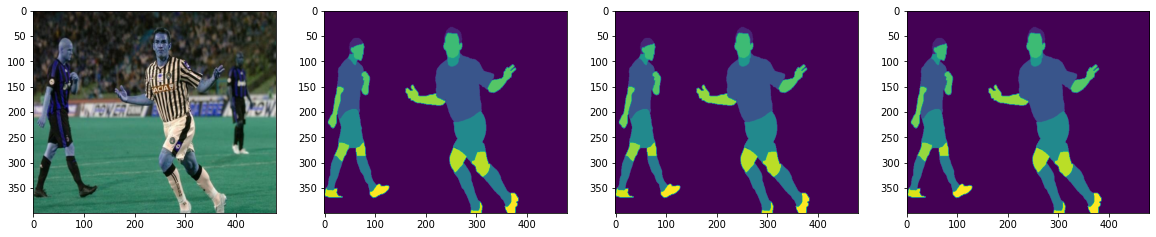

In [29]:
image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', 75)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 75)[0]

print(image_path, mask_path)

image, mask_orig, mask_processed, mask_stack = process_image_and_mask_no_merge(image_path, mask_path)

fig = plt.figure(figsize=(20, 14))

fig.add_subplot(1, 4, 1)
plt.imshow(image)

fig.add_subplot(1, 4, 2)
plt.imshow(mask_orig)

fig.add_subplot(1, 4, 3)
plt.imshow(mask_processed)

mask_stack_org = np.argmax(mask_stack, axis=-1)
mask_stack_org = mask_stack_org.astype(np.float32)

fig.add_subplot(1, 4, 4)
plt.imshow(mask_stack_org)

print(mask_stack.shape, mask_stack_org.shape)

In [30]:
# we have to create this function for piplining, beacuse when we want to read (decode) tensor object we have to do this in an intermediate function

def preprocess_no_merge(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image, _, _, mask_stack = process_image_and_mask_no_merge(x, y)
        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT_0, IMG_WIDTH_0, N_CHANNELS_0])
    mask_stack.set_shape([IMG_HEIGHT_0, IMG_WIDTH_0, N_CLASSES_0])

    return image, mask_stack

In [31]:
# create the pipeline

def tf_dataset_no_merge(image_paths, mask_paths, batch_size=32):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess_no_merge, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [32]:
train_data_0 = tf_dataset_no_merge(train_x, train_y, batch_size=BATCH_SIZE_PARSING_0)
valid_data_0 = tf_dataset_no_merge(valid_x, valid_y, batch_size=BATCH_SIZE_PARSING_0)
test_data_0 = tf_dataset_no_merge(test_x, test_y, batch_size=BATCH_SIZE_PARSING_0)

train_data_0, valid_data_0, test_data_0

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 20), dtype=tf.uint8, name=None))>)

(400, 480, 3) (400, 480, 20) (400, 480)
tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=uint8)
0.0 19.0
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0}


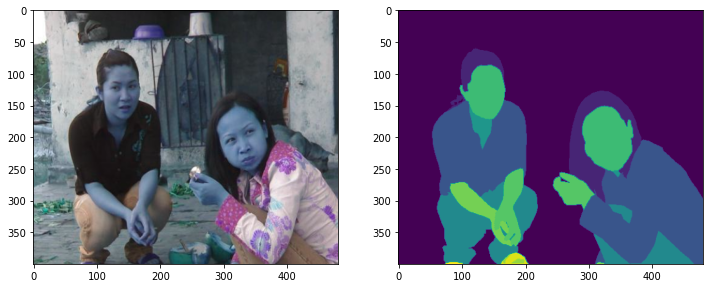

In [33]:
for x, y in train_data_0.take(1):

  index = 8

  image = x[index]

  mask = np.argmax(y[index], axis=-1)
  mask = mask.astype(np.float32)

  fig = plt.figure(figsize=(12, 8))

  fig.add_subplot(1, 2, 1)
  plt.imshow(image)

  fig.add_subplot(1, 2, 2)
  plt.imshow(mask)

  print(image.shape, y[index].shape, mask.shape)

  print(y[index][-4][1])

  print(np.amin(mask), np.amax(mask))

  print(set(mask.flatten()))

  break

In [34]:
INITIAL_LR = 1e-3
MIN_LR = 1e-6
LR_REDUCTION_FACTOR = 0.1
LR_REUCTION_PATIENCE = 2

EARLY_STOPPING_PATIENCE = 2

EPOCHS = 5
VERBOSE = 2
# BATCH_SIZE_PARSING = 16 # defined as global parameter for human parsing model

# These file names refer to names by which model weights files will be saved or loaded: model_parsing_[model_number]_[saved_file_number]
WEIGHT_FILE_NAME = 'model_parsing_0_0.h5'
MODEL_FILE_NAME = 'model_parsing_0_1.h5'

model_parsing_0 = build_unet_model(input_shape=(IMG_HEIGHT_0, IMG_WIDTH_0, N_CHANNELS_0), n_classes=N_CLASSES_0)

if run_model_parsing_0:

  model_parsing_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

  callbacks = [
      ModelCheckpoint(os.path.join(saved_models_path, WEIGHT_FILE_NAME), save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=LR_REDUCTION_FACTOR, patience=LR_REUCTION_PATIENCE, min_lr=MIN_LR),
      EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE),
  ]

  model_parsing_0.fit(train_data_0, steps_per_epoch=len(train_data_0),
                      validation_data=valid_data_0, validation_steps=len(valid_data_0),
                      epochs=EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE_PARSING_0, callbacks=callbacks)
  
  model_parsing_0.save(os.path.join(saved_models_path, MODEL_FILE_NAME))

else:

  # currently we are using saved model as model weight file
  model_parsing_0 = load_model(os.path.join(saved_models_path, WEIGHT_FILE_NAME))

model_parsing_0.summary()

# visualize a plot of model
# tf.keras.utils.plot_model(model_parsing_0, show_shapes=True,)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 20), dtype=tf.float32, name=None), name='activation_18/Softmax:0', description="created by layer 'activation_18'")


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 400, 480, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 400, 480, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                               

f1 =  0.48735426101114016
f1 =  0.1638649536764743
f1 =  0.2394038506558793
CPU times: user 2min 17s, sys: 153 ms, total: 2min 18s
Wall time: 1min 40s


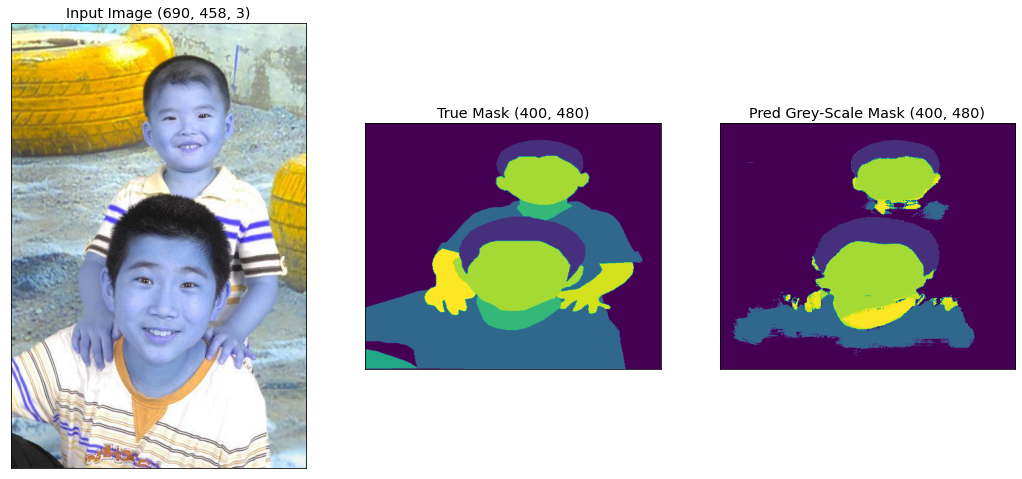

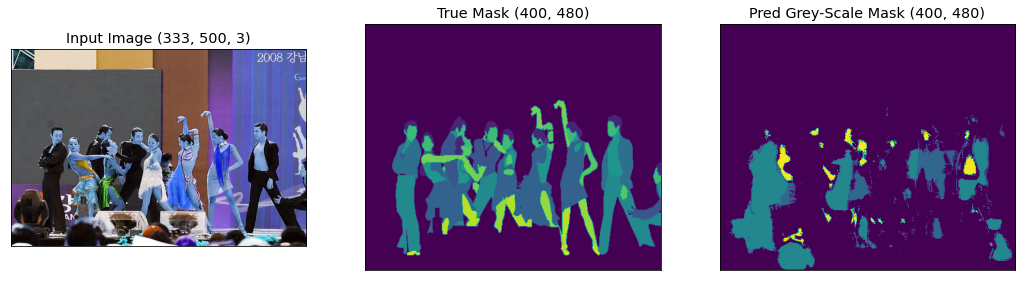

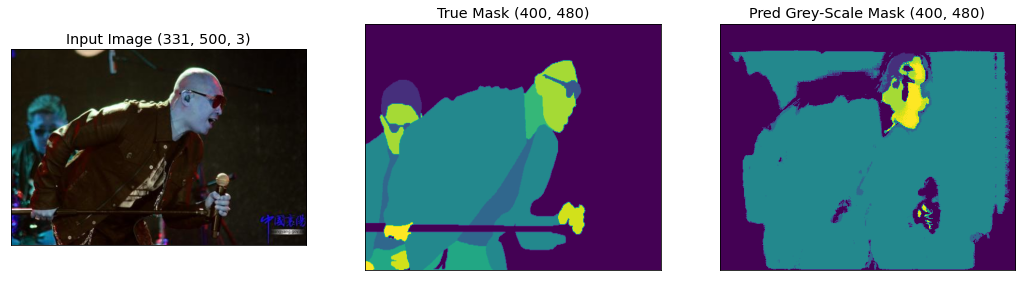

In [35]:
%%time

for _ in range(3):
  plot_and_predict_model(class_labels, model_parsing_0, process_image_and_mask_no_merge)

**MODEL 1 HERE**

Hyper-Parameters


*   IMG_HEIGHT_1 = 320
*   IMG_WIDTH_1 = 416
*   N_CHANNELS_1 = 3
*   N_CLASSES_1 = 8
*   BATCH_SIZE_PARSING_1 = 32

*   TRAINING_DATA_1 = 5% or 1131 images
*   INITIAL_LR = 1e-3
*   EPOCHS = 5


In [36]:
# ['Background', 'UpperClothes', 'Dress', 'Pants', 'Face', 'Left-arm', 'Left-leg']
# replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16], [[12], 9]]

replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[8, 17, 18, 19], 16], [[12], 9]]
replaced_indexes = np.concatenate([i for i, j in replace_array])

remaining_indexes = [i for i in  np.arange(20) if i not in replaced_indexes]

print(replaced_indexes)
print(remaining_indexes)

merged_class_labels = []
for i in range(len(class_labels)):
  if i not in replaced_indexes:
    merged_class_labels.append(class_labels[i])

print(merged_class_labels)
print(len(merged_class_labels))

def merge_classes(mask_image_array):

  """
  replace_array = [ [ [ replace_from ], replace_to] ]
  """

  # mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
  mask_merged = mask_image_array

  for i, j in replace_array:
    mask_merged = np.select([mask_merged == k for k in i], [j for _ in i], mask_merged)

  # after merging values are from 0-19 so we make them 0-6
  for i in remaining_indexes:
    mask_merged = np.select([mask_merged == i], [np.where(remaining_indexes == i)], mask_merged)

  return mask_merged

[ 1  2  4 10 11  3 15  8 17 18 19 12]
[0, 5, 6, 7, 9, 13, 14, 16]
['Background', 'UpperClothes', 'Dress', 'Coat', 'Pants', 'Face', 'Left-arm', 'Left-leg']
8


In [37]:
IMG_HEIGHT_1 = 320
IMG_WIDTH_1 = 416

N_CHANNELS_1 = 3

N_CLASSES_1 = len(merged_class_labels)

BATCH_SIZE_PARSING_1 = 32

print(N_CLASSES_1)

8


In [38]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Category_ids', dataset_ratio=0.05)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Category_ids', dataset_ratio=0.05)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(1131, 1131, 283, 283, 250, 250)

In [39]:
def process_image_and_mask_with_merge(image_path, mask_path):

  is_allow_merge=True

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH_1, IMG_HEIGHT_1)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_WIDTH_1, IMG_HEIGHT_1)) # (W,H)

  mask_orig = mask
  mask_processed = mask

  # This will merge unwanted mask classes
  if is_allow_merge:
    mask_processed = merge_classes(mask_image_array = mask)

  # mask normalization is different from simply /255, below we are doing mask normalization, it is one-hot encoding in our case
  mask_objects = []
  for gray_scale_value in range(N_CLASSES_1):
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(np.expand_dims(mask_processed, axis=-1), gray_scale_value), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  # print(mask_stack)

  return image, mask_orig, mask_processed, mask_stack

/content/CIHP/Validation/Images/0000870.jpg /content/CIHP/Validation/Category_ids/0000870.png
(320, 416, 8) (320, 416)


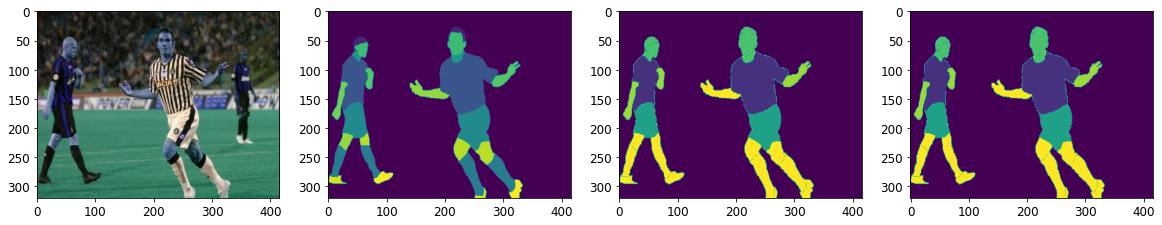

In [40]:
image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', 75)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 75)[0]

print(image_path, mask_path)

image, mask_orig, mask_processed, mask_stack = process_image_and_mask_with_merge(image_path, mask_path)

fig = plt.figure(figsize=(20, 14))

fig.add_subplot(1, 4, 1)
plt.imshow(image)

fig.add_subplot(1, 4, 2)
plt.imshow(mask_orig)

fig.add_subplot(1, 4, 3)
plt.imshow(mask_processed)

mask_stack_org = np.argmax(mask_stack, axis=-1)
mask_stack_org = mask_stack_org.astype(np.float32)

fig.add_subplot(1, 4, 4)
plt.imshow(mask_stack_org)

print(mask_stack.shape, mask_stack_org.shape)

In [41]:
# we have to create this function for piplining, beacuse when we want to read (decode) tensor object we have to do this in an intermediate function

def preprocess_with_merge(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        processed_reult = process_image_and_mask_with_merge(x, y)
        image, _, _, mask_stack = processed_reult

        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT_1, IMG_WIDTH_1, N_CHANNELS_1])
    mask_stack.set_shape([IMG_HEIGHT_1, IMG_WIDTH_1, N_CLASSES_1])

    return image, mask_stack

In [42]:
# create the pipeline

def tf_dataset_with_merge(image_paths, mask_paths, batch_size=32):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess_with_merge, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [43]:
train_data_1 = tf_dataset_with_merge(train_x, train_y, batch_size=BATCH_SIZE_PARSING_1)
valid_data_1 = tf_dataset_with_merge(valid_x, valid_y, batch_size=BATCH_SIZE_PARSING_1)
test_data_1 = tf_dataset_with_merge(test_x, test_y, batch_size=BATCH_SIZE_PARSING_1)

train_data_1, valid_data_1, test_data_1

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 8), dtype=tf.uint8, name=None))>)

(320, 416, 3) (320, 416, 8) (320, 416)
tf.Tensor([0 1 0 0 0 0 0 0], shape=(8,), dtype=uint8)
0.0 7.0
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


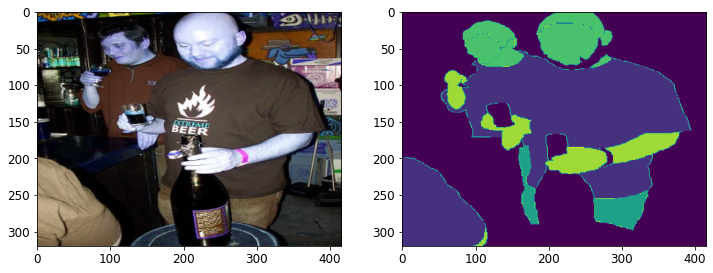

In [44]:
for x, y in train_data_1.take(1):

  index = 8

  image = x[index]

  mask = np.argmax(y[index], axis=-1)
  mask = mask.astype(np.float32)

  fig = plt.figure(figsize=(12, 8))

  fig.add_subplot(1, 2, 1)
  plt.imshow(image)

  fig.add_subplot(1, 2, 2)
  plt.imshow(mask)

  print(image.shape, y[index].shape, mask.shape)

  print(y[index][-4][1])

  print(np.amin(mask), np.amax(mask))

  print(set(mask.flatten()))

  break

In [45]:
%%time

INITIAL_LR = 1e-3
MIN_LR = 1e-6
LR_REDUCTION_FACTOR = 0.1
LR_REUCTION_PATIENCE = 2

EARLY_STOPPING_PATIENCE = 2

EPOCHS = 5
VERBOSE = 2
# BATCH_SIZE_PARSING = 16 # defined as global parameter for human parsing model

# These file names refer to names by which model weights files will be saved or loaded: model_parsing_[model_number]_[saved_file_number]
WEIGHT_FILE_NAME = 'model_parsing_4_2.h5'
MODEL_FILE_NAME = 'model_parsing_4_3.h5'

model_parsing_1 = build_unet_model(input_shape=(IMG_HEIGHT_1, IMG_WIDTH_1, N_CHANNELS_1), n_classes=N_CLASSES_1)

if run_model_parsing_1:

  model_parsing_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

  callbacks = [
      ModelCheckpoint(os.path.join(saved_models_path, WEIGHT_FILE_NAME), save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=LR_REDUCTION_FACTOR, patience=LR_REUCTION_PATIENCE, min_lr=MIN_LR),
      EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE),
  ]

  model_parsing_1.fit(train_data_1, steps_per_epoch=len(train_data_1),
                      validation_data=valid_data_1, validation_steps=len(valid_data_1),
                      epochs=EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE_PARSING_1, callbacks=callbacks)
  
  model_parsing_1.save(os.path.join(saved_models_path, MODEL_FILE_NAME))

else:

  # currently we are using saved model as model weight file
  model_parsing_1 = load_model(os.path.join(saved_models_path, MODEL_FILE_NAME))
  # model_parsing_4.load_weights(os.path.join(saved_models_path, WEIGHT_FILE_NAME))

model_parsing_1.summary()

# visualize a plot of model
# tf.keras.utils.plot_model(model_parsing_0, show_shapes=True,)

KerasTensor(type_spec=TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 320, 416, 8), dtype=tf.float32, name=None), name='activation_37/Softmax:0', description="created by layer 'activation_37'")
Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 320, 416, 64  1792        ['input_1[0][0]']                
                                )                     

f1 =  0.5078805552393455
f1 =  0.2853638001945806
f1 =  0.22027499729756822
CPU times: user 1min 35s, sys: 109 ms, total: 1min 35s
Wall time: 49.8 s


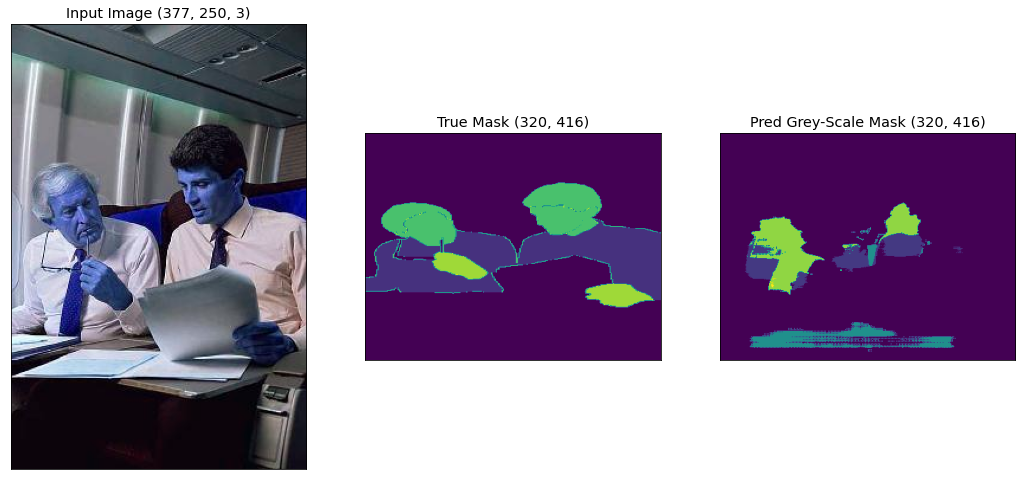

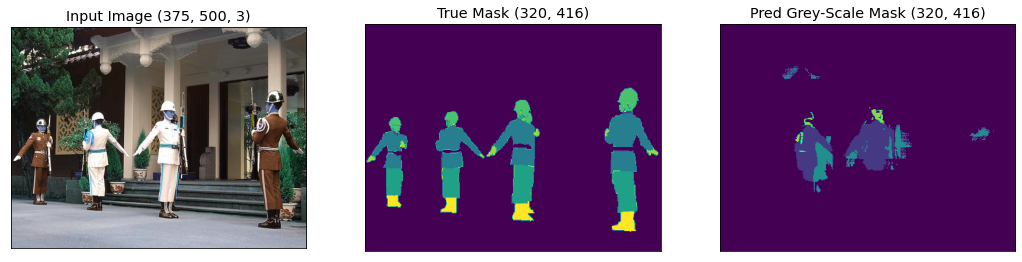

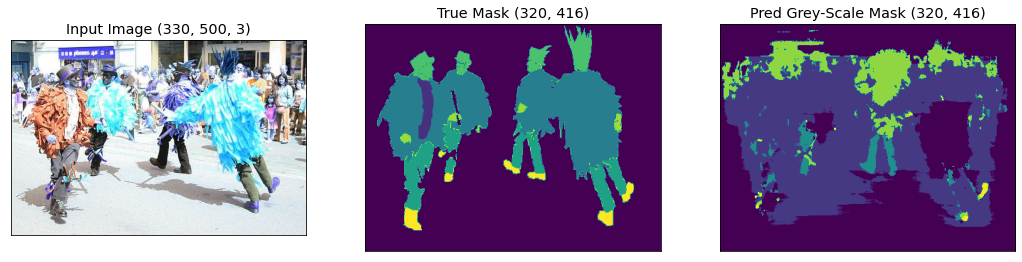

In [53]:
%%time

for _ in range(3):
  plot_and_predict_model(merged_class_labels, model_parsing_1, process_image_and_mask_with_merge)

**MODEL 2 HERE**

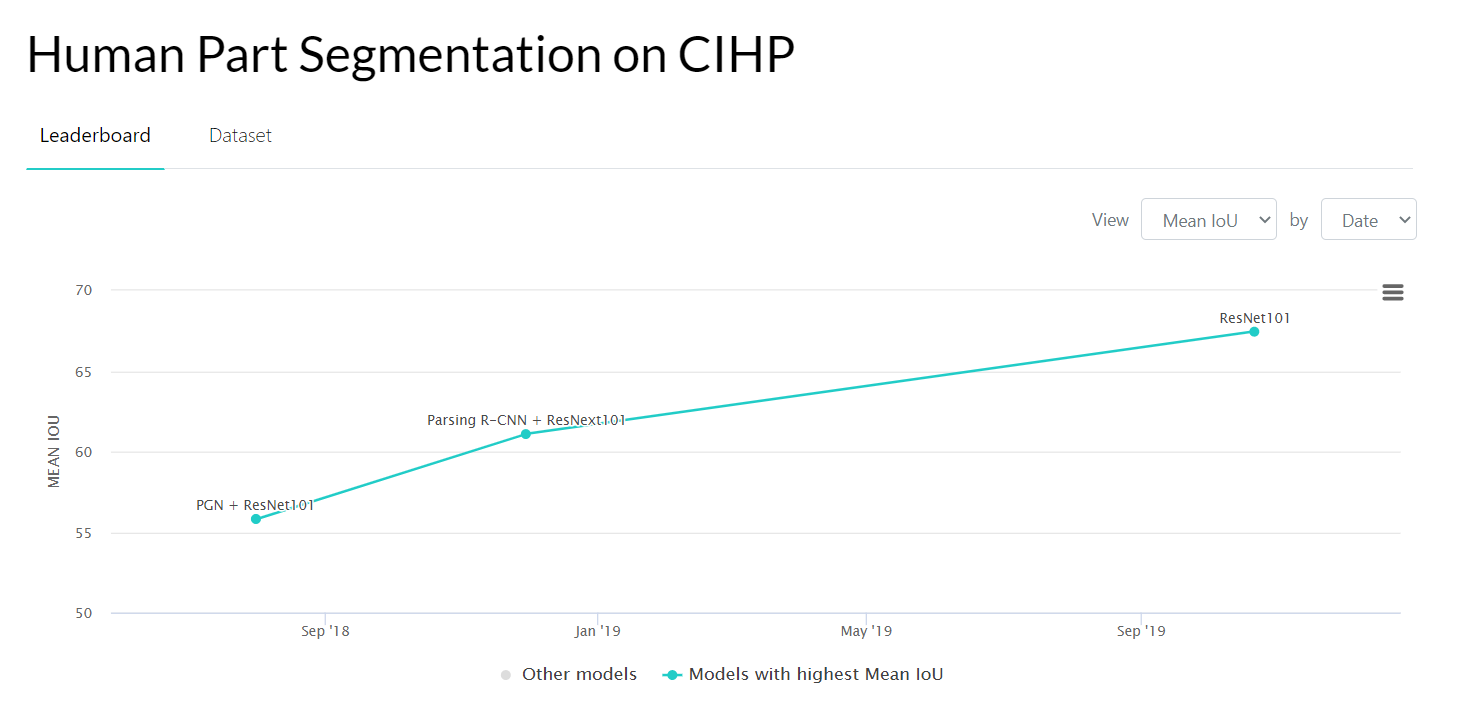

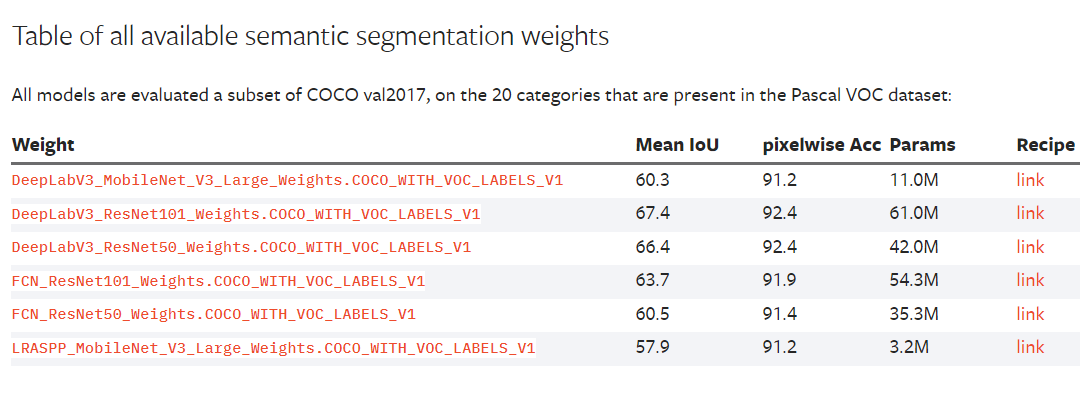

In [47]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.DEFAULT
model_parsing_5 = deeplabv3_resnet101(weights=weights)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [48]:
model_parsing_5.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Notes:



*   When using 400x480 image the unwanted boundaries in image were reduced

